In [1]:
# system tools
import warnings
import json
import sys
import string
import ast

# data cleaning + analysis tools
import pandas as pd
import datetime as dt
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

#nltk tools
import lda #Latent Dirichlet Allocation (create topics)
import gensim
from gensim import corpora, models #for constructing document term matrix
#from stop_words import get_stop_words
from gensim.models import Phrases
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.util import ngrams

#set notebook preferences
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

### Import JSON file with city metadata - including which cities have sufficient Public Record Request (PRR) data for analysis

In [2]:
json_file = '../data/cities.json'

with open(json_file, 'r') as f:
    md = json.load(f)

###  Create dataframe of PRR data for all relevant cities

In [3]:
data_raw = pd.DataFrame(columns = ['city', 'month_year', 'Summary'])
city_list = []
for key, value in md.items():
    city = value['name']
    filepath = '/Users/alenastern/Google Drive File Stream/My Drive/Alena_Project/PR_Data/{}.csv'.format(city)
    if value["desc"] == "Y":
        try:
            df = pd.read_csv(filepath)
        except:
            try:
                df = pd.read_csv(filepath, encoding='mac_roman')
            except:
                continue
        print(key)
        name = key.split(' ')
        city_list.append(name[0].lower())
    else:
        continue
    
    try:
        df['Create Date'] = pd.to_datetime(df['Create Date'])
    except:
        df['New'] = pd.to_datetime(df['Create Date'].apply(lambda x: re.findall('^\S*', x)[0]))
        df.drop(columns=['Create Date'], inplace = True)
        df.rename(index=str, columns={"New": "Create Date"}, inplace = True)

    df['month_year'] = df['Create Date'].dt.to_period('M')
    
    mc = df[['month_year', 'Summary']]
    mc['city'] = city
    
    data_raw = pd.concat([data_raw, mc])

Arlington city
Asheville city
Bainbridge Island city
Boulder County
Cathedral City city
Dayton city
Denton city
Everett city
Fort Collins city
Greensboro city
Hayward city
Kirkland city
Las Cruces city
Lynnwood city
Mercer Island city
Miami city
Middleborough town
New Orleans city
Oakland city
Oklahoma City city
Olympia city
Palo Alto city
Peoria city
Pullman city
Rancho Cucamonga city
Redmond city
Renton city
Sacramento city
San Francisco city
Tukwila city
Vallejo city
West Sacramento city
Winchester city


#### We can see the raw data below. Our raw dataset includes 86,416 PRRs from 33 different cities

In [6]:
data_raw.to_csv('data_raw.csv')

In [3]:
data_raw = pd.read_csv('data_raw.csv')

In [6]:
data_raw.head()

,Summary,city,month_year
0,"We are working with an engineering firm on an upcoming project. They have asked us to gather maps for this project. Would you be able to assist me in gathering maps/records (as builds) for any underground water facilities you may have? Something just showing the route of the water lines would do.\n\n207th ST NE to 92nd Ave NE, Arlington, Cascade Surveying & Engineering \n\nI have attached the scope for your convenience. Please let me know if you have questions.",Arlington,2018-06
1,"Need copies of contracts and all related documents pertaining to Topcub Aircraft property located at 17922 59th DR NE Arlington WA 98223 between Arlington Airport, Topcub Aircraft, City of Arlington, HCI Steel Buildings and PUD.",Arlington,2018-06
2,"Copies of Building Permits of $5,000 valuation and up ($20,000 min for Re-Roofs), ($50,000 min. for Cell Tower upgrades), (Electrical, Mechanical & Plumbing at $100,000 min.) and (Solar Panels, Swimming Pools & Foundations at any valuation)",Arlington,2018-06
3,"police report filed to an officer against Wayne Parris (DOB 08-03-1957) from Brittany J. Parris. The paperwork I have has a case number D18-39 it is also stamped at the bottom with 18-1294, Iím not sure which number you will need. If there is any other information needed please let me know.",Arlington,2018-06
4,"Email Communications between Stephanie Shook, Dave Kraski, Bruce Stedman and Chad Schmidt in regards to Fire Protection District 21 billing and passage of contract for ALS Services. \n\nAlso any copies of Agenda Bills, D21 Contract and materials presented for review in Nov/Dec time frame in regards to the contract.",Arlington,2018-06


In [4]:
data_raw.shape

(86416, 3)

In [5]:
len(data_raw.city.unique())

33

In [6]:
data_raw.index = pd.RangeIndex(len(data_raw.index))

In [7]:
data_raw.reset_index(inplace=True)

### Create dataframe for cleaning by removing null summaries

In [8]:
data = data_raw.dropna(subset=['Summary'])

In [9]:
data.head()

,index,Summary,city,month_year
0,0,"We are working with an engineering firm on an upcoming project. They have asked us to gather maps for this project. Would you be able to assist me in gathering maps/records (as builds) for any underground water facilities you may have? Something just showing the route of the water lines would do.\n\n207th ST NE to 92nd Ave NE, Arlington, Cascade Surveying & Engineering \n\nI have attached the scope for your convenience. Please let me know if you have questions.",Arlington,2018-06
1,1,"Need copies of contracts and all related documents pertaining to Topcub Aircraft property located at 17922 59th DR NE Arlington WA 98223 between Arlington Airport, Topcub Aircraft, City of Arlington, HCI Steel Buildings and PUD.",Arlington,2018-06
2,2,"Copies of Building Permits of $5,000 valuation and up ($20,000 min for Re-Roofs), ($50,000 min. for Cell Tower upgrades), (Electrical, Mechanical & Plumbing at $100,000 min.) and (Solar Panels, Swimming Pools & Foundations at any valuation)",Arlington,2018-06
3,3,"police report filed to an officer against Wayne Parris (DOB 08-03-1957) from Brittany J. Parris. The paperwork I have has a case number D18-39 it is also stamped at the bottom with 18-1294, Iím not sure which number you will need. If there is any other information needed please let me know.",Arlington,2018-06
4,4,"Email Communications between Stephanie Shook, Dave Kraski, Bruce Stedman and Chad Schmidt in regards to Fire Protection District 21 billing and passage of contract for ALS Services. \n\nAlso any copies of Agenda Bills, D21 Contract and materials presented for review in Nov/Dec time frame in regards to the contract.",Arlington,2018-06


#### Function to convert nltk part of speech tags to wordnet tags (we use this to stem the words in data cleaning below):

In [10]:
def get_wordnet_pos(tag):

    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

## Clean PRR data to prepare for LDA analysis

In [11]:
# Turn to lowercase
data['sum_ed'] = data.Summary.str.lower()

# Remove all punctuation
translator = str.maketrans('','', string.punctuation)
data.sum_ed = data.sum_ed.str.translate(translator)

# Remove all city names
for city in city_list:
    data.sum_ed = data.sum_ed.str.replace(city, '')

# Remove all state names
state_list = ['washington', 'north carolina', 'colorado', 'california',
             'ohio', 'texas', 'new mexico', 'florida', 'massachusetts',
             'lousiana', 'oklahoma', 'arizona', 'rhode island', 'virginia']

for state in state_list:
     data.sum_ed = data.sum_ed.str.replace(state, '')
    
# Remove digits
dig_translator = str.maketrans('','', string.digits)
data.sum_ed = data.sum_ed.str.translate(dig_translator)

#remove empty strings, stopwords and stem
stop_words = set(stopwords.words('english'))
lmtzr = WordNetLemmatizer()
data['token'] = data['sum_ed'].apply(lambda x: nltk.word_tokenize(x))
data['lemma'] = data['token'].apply(lambda x: nltk.pos_tag(x))
data['mash'] = data['lemma'].apply(lambda x: [lmtzr.lemmatize(i[0], get_wordnet_pos(i[1])) for i in x if len(i[0]) > 0 and i[0] not in stop_words])

# Remove whitespace
wsp_translator = str.maketrans('','', string.whitespace)
data['mash'] = data['mash'].apply(lambda x: [i.translate(wsp_translator) for i in x])

# Remove empty lists
data['mash_len'] = data['mash'].apply(lambda x: len(x))
data = data[data['mash_len'] > 0]

# Create bigrams
data['bigrams'] = data['mash'].apply(lambda x: ["_".join(w) for w in ngrams(x, 2)])
    

In [12]:
data.head()

,index,Summary,city,month_year,sum_ed,token,lemma,mash,mash_len,bigrams
0,0,"We are working with an engineering firm on an upcoming project. They have asked us to gather maps for this project. Would you be able to assist me in gathering maps/records (as builds) for any underground water facilities you may have? Something just showing the route of the water lines would do.\n\n207th ST NE to 92nd Ave NE, Arlington, Cascade Surveying & Engineering \n\nI have attached the scope for your convenience. Please let me know if you have questions.",Arlington,2018-06,we are working with an engineering firm on an upcoming project they have asked us to gather maps for this project would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have something just showing the route of the water lines would do\n\nth st ne to nd ave ne cascade surveying engineering \n\ni have attached the scope for your convenience please let me know if you have questions,"[we, are, working, with, an, engineering, firm, on, an, upcoming, project, they, have, asked, us, to, gather, maps, for, this, project, would, you, be, able, to, assist, me, in, gathering, mapsrecords, as, builds, for, any, underground, water, facilities, you, may, have, something, just, showing, the, route, of, the, water, lines, would, do, th, st, ne, to, nd, ave, ne, cascade, surveying, engineering, i, have, attached, the, scope, for, your, convenience, please, let, me, know, if, you, have, questions]","[(we, PRP), (are, VBP), (working, VBG), (with, IN), (an, DT), (engineering, NN), (firm, NN), (on, IN), (an, DT), (upcoming, JJ), (project, NN), (they, PRP), (have, VBP), (asked, VBN), (us, PRP), (to, TO), (gather, VB), (maps, NNS), (for, IN), (this, DT), (project, NN), (would, MD), (you, PRP), (be, VB), (able, JJ), (to, TO), (assist, VB), (me, PRP), (in, IN), (gathering, VBG), (mapsrecords, NNS), (as, IN), (builds, NNS), (for, IN), (any, DT), (underground, JJ), (water, NN), (facilities, NNS), (you, PRP), (may, MD), (have, VB), (something, NN), (just, RB), (showing, VBG), (the, DT), (route, NN), (of, IN), (the, DT), (water, NN), (lines, NNS), (would, MD), (do, VB), (th, VB), (st, VB), (ne, JJ), (to, TO), (nd, VB), (ave, VB), (ne, JJ), (cascade, NN), (surveying, VBG), (engineering, NN), (i, NN), (have, VBP), (attached, VBN), (the, DT), (scope, NN), (for, IN), (your, PRP$), (convenience, NN), (please, NN), (let, VB), (me, PRP), (know, VB), (if, IN), (you, PRP), (have, VBP), (questions...","[work, engineering, firm, upcoming, project, ask, u, gather, map, project, would, able, assist, gather, mapsrecords, build, underground, water, facility, may, something, show, route, water, line, would, th, st, ne, nd, ave, ne, cascade, survey, engineering, attach, scope, convenience, please, let, know, question]",42,"[work_engineering, engineering_firm, firm_upcoming, upcoming_project, project_ask, ask_u, u_gather, gather_map, map_project, project_would, would_able, able_assist, assist_gather, gather_mapsrecords, mapsrecords_build, build_underground, underground_water, water_facility, facility_may, may_something, something_show, show_route, route_water, water_line, line_would, would_th, th_st, st_ne, ne_nd, nd_ave, ave_ne, ne_cascade, cascade_survey, survey_engineering, engineering_attach, attach_scope, scope_convenience, convenience_please, please_let, let_know, know_question]"
1,1,"Need copies of contracts and all related documents pertaining to Topcub Aircraft property located at 17922 59th DR NE Arlington WA 98223 between Arlington Airport, Topcub Aircraft, City of Arlington, HCI Steel Buildings and PUD.",Arlington,2018-06,need copies of contracts and all related documents pertaining to topcub aircraft property located at th dr ne wa between airport topcub aircraft city of hci steel buildings and pud,"[need, copies, of, contracts, and, all, related, documents, pertaining, to, topcub, aircraft, property, located, at, th, dr, ne, wa, between, airport, topcub

### Identify and remove commonly used words in PRRs

In [34]:
word_list = [y for x in list(data['mash']) for y in x]
counts = Counter(word_list)
Counter(word_list).most_common(50)

[('report', 30544),
 ('request', 29113),
 ('record', 26821),
 ('city', 18382),
 ('please', 18067),
 ('copy', 17480),
 ('police', 13216),
 ('date', 13110),
 ('property', 11584),
 ('street', 11495),
 ('information', 10945),
 ('th', 10631),
 ('number', 10611),
 ('driver', 10537),
 ('would', 9966),
 ('include', 9398),
 ('document', 9380),
 ('provide', 9242),
 ('wa', 8842),
 ('public', 8796),
 ('permit', 8660),
 ('case', 8620),
 ('accident', 7879),
 ('st', 7845),
 ('location', 7798),
 ('like', 7595),
 ('state', 7446),
 ('email', 7236),
 ('thank', 7219),
 ('incident', 7213),
 ('address', 6804),
 ('regard', 6730),
 ('insurance', 6498),
 ('ne', 6383),
 ('building', 6376),
 ('relate', 6349),
 ('ave', 6224),
 ('department', 6089),
 ('plan', 5736),
 ('type', 5709),
 ('county', 5615),
 ('company', 5538),
 ('following', 5506),
 ('file', 5458),
 ('fire', 5334),
 ('code', 5296),
 ('auto', 5273),
 ('loss', 5202),
 ('need', 5041),
 ('insure', 4963)]

In [ ]:
Counter(word_list).most_common()[-50:-1]

In [18]:
common_list = ['report', 'request', 'record', 'city', 'please', 'copy', 'date', 'information', 'would',
              'include', 'document', 'provide', 'like', 'thank', 'need', 'know', 'thanks']

In [3]:
"request" in common_list

True

In [19]:
# remove general words that are common to public record requests

#for word in common_list:
data['mash'] = data['mash'].apply(lambda x: [i for i in x if i not in common_list])

In [20]:
# remove number suffixes
suffix_list = ['th', 'nd', 'st', 'rd']
#for word in suffix_list:
data['mash'] = data['mash'].apply(lambda x: [i for i in x if i not in suffix_list])

In [21]:
# remove city and state abbreviations
abbv_list = ['wa', 'nc', 'co', 'ca', 'oh', 'tx', 'nm', 'fl', 'ma', 'la', 'ok', 'az', 'ri', 'va', 
             'francisco', 'sf', 'okc', 'lv', 'nola', 'slc']
#for word in suffix_list:
data['mash'] = data['mash'].apply(lambda x: [i for i in x if i not in abbv_list])

In [22]:
data.head()

,index,Summary,city,month_year,sum_ed,token,lemma,mash,mash_len,bigrams,common_bigrams
0,0,"We are working with an engineering firm on an upcoming project. They have asked us to gather maps for this project. Would you be able to assist me in gathering maps/records (as builds) for any underground water facilities you may have? Something just showing the route of the water lines would do.\n\n207th ST NE to 92nd Ave NE, Arlington, Cascade Surveying & Engineering \n\nI have attached the scope for your convenience. Please let me know if you have questions.",Arlington,2018-06,we are working with an engineering firm on an upcoming project they have asked us to gather maps for this project would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have something just showing the route of the water lines would do\n\nth st ne to nd ave ne cascade surveying engineering \n\ni have attached the scope for your convenience please let me know if you have questions,"[we, are, working, with, an, engineering, firm, on, an, upcoming, project, they, have, asked, us, to, gather, maps, for, this, project, would, you, be, able, to, assist, me, in, gathering, mapsrecords, as, builds, for, any, underground, water, facilities, you, may, have, something, just, showing, the, route, of, the, water, lines, would, do, th, st, ne, to, nd, ave, ne, cascade, surveying, engineering, i, have, attached, the, scope, for, your, convenience, please, let, me, know, if, you, have, questions]","[(we, PRP), (are, VBP), (working, VBG), (with, IN), (an, DT), (engineering, NN), (firm, NN), (on, IN), (an, DT), (upcoming, JJ), (project, NN), (they, PRP), (have, VBP), (asked, VBN), (us, PRP), (to, TO), (gather, VB), (maps, NNS), (for, IN), (this, DT), (project, NN), (would, MD), (you, PRP), (be, VB), (able, JJ), (to, TO), (assist, VB), (me, PRP), (in, IN), (gathering, VBG), (mapsrecords, NNS), (as, IN), (builds, NNS), (for, IN), (any, DT), (underground, JJ), (water, NN), (facilities, NNS), (you, PRP), (may, MD), (have, VB), (something, NN), (just, RB), (showing, VBG), (the, DT), (route, NN), (of, IN), (the, DT), (water, NN), (lines, NNS), (would, MD), (do, VB), (th, VB), (st, VB), (ne, JJ), (to, TO), (nd, VB), (ave, VB), (ne, JJ), (cascade, NN), (surveying, VBG), (engineering, NN), (i, NN), (have, VBP), (attached, VBN), (the, DT), (scope, NN), (for, IN), (your, PRP$), (convenience, NN), (please, NN), (let, VB), (me, PRP), (know, VB), (if, IN), (you, PRP), (have, VBP), (questions...","[work, engineering, firm, upcoming, project, ask, u, gather, map, project, able, assist, gather, mapsrecords, build, underground, water, facility, may, something, show, route, water, line, ne, ave, ne, cascade, survey, engineering, attach, scope, convenience, let, question]",42,"[work_engineering, engineering_firm, firm_upcoming, upcoming_project, project_ask, ask_u, u_gather, gather_map, map_project, project_would, would_able, able_assist, assist_gather, gather_mapsrecords, mapsrecords_build, build_underground, underground_water, water_facility, facility_may, may_something, something_show, show_route, route_water, water_line, line_would, would_th, th_st, st_ne, ne_nd, nd_ave, ave_ne, ne_cascade, cascade_survey, survey_engineering, engineering_attach, attach_scope, scope_convenience, convenience_please, please_let, let_know, know_question]",[]
1,1,"Need copies of contracts and all related documents pertaining to Topcub Aircraft property located at 17922 59th DR NE Arlington WA 98223 between Arlington Airport, Topcub Aircraft, City of Arlington, HCI Steel Buildings and PUD.",Arlington,2018-06,need copies of contracts and all related documents pertaining to topcub aircraft property located at th dr ne wa between airport topcub aircraft city of hci steel buildings and pud,"[need, copies, of, contracts, and, all, related, documents, pertaining, to, topcub, aircraft, property, located, at, th, dr, ne, wa, between, airport, topcub, aircraft, city, of, 

In [49]:
# convert str to list
data['mash'] =  data['mash'].apply(lambda x:  ast.literal_eval(x))

data['mash2'] =  data['mash2'].apply(lambda x:  ast.literal_eval(x))

In [ ]:
common_bigrams = ['police_report', 'public_record', 'insurance_company', 'location_loss', 'date_occurrence', 'reportcase_number',
'insure_driver', 'auto_accident', 'occurrence_location', 'transactionreference_insurance', 'number_date', 'type_auto',
'accident_reportcase', 'code_violation', 'copy_police', 'incident_report', 'police_department', 'certificate_occupancy',
'accident_report', 'property_locate', 'storage_tank','driver_note', 'building_permit', 'driver_driver','case_number', 
 'hazardous_material', 'collision_report', 'state_farm', 'site_plan', 'fire_department', 'ftp_report', 'auto_theft',
 'fire_code', 'request_police', 'farm_claim', 'claim_compass', 'site_assessment', 'compass_report', 'environmental_site', 
 'tax_sale', 'loss_cross','city_council', 'code_enforcement', 'subject_property', 'report_case', 'phase_environmental', 
 'report_incident', 'date_loss', 'police_case', 'witness_statement']
 

In [14]:
bigram_list = [y for x in list(data['bigrams']) for y in x]
counts = Counter(bigram_list)
Counter(bigram_list).most_common(100)

[('police_report', 6824),
 ('would_like', 6480),
 ('please_provide', 5679),
 ('public_record', 4987),
 ('insurance_company', 4454),
 ('location_loss', 4331),
 ('report_type', 4327),
 ('date_occurrence', 4317),
 ('cross_street', 4287),
 ('reportcase_number', 4267),
 ('insure_driver', 4239),
 ('auto_accident', 4235),
 ('occurrence_location', 4221),
 ('transactionreference_insurance', 4204),
 ('state_wa', 4189),
 ('wa_insure', 4144),
 ('number_date', 4040),
 ('street_city', 3816),
 ('city_county', 3761),
 ('type_auto', 3545),
 ('accident_reportcase', 3020),
 ('request_copy', 2771),
 ('county_snohomish', 2729),
 ('snohomish_state', 2712),
 ('record_request', 2603),
 ('th_ave', 2529),
 ('code_violation', 2059),
 ('like_request', 2048),
 ('copy_police', 1990),
 ('incident_report', 1965),
 ('th_st', 1904),
 ('ne_th', 1818),
 ('th_street', 1750),
 ('police_department', 1724),
 ('certificate_occupancy', 1637),
 ('accident_report', 1625),
 ('record_act', 1625),
 ('provide_copy', 1595),
 ('proper

In [16]:
common_bigrams = ['police_report', 'public_record', 'insurance_company', 'location_loss', 'date_occurrence', 'reportcase_number',
'insure_driver', 'auto_accident', 'occurrence_location', 'transactionreference_insurance', 'number_date', 'type_auto',
'accident_reportcase', 'code_violation', 'copy_police', 'incident_report', 'police_department', 'certificate_occupancy',
'accident_report', 'property_locate', 'storage_tank','driver_note', 'building_permit', 'driver_driver','case_number', 
 'hazardous_material', 'collision_report', 'state_farm', 'site_plan', 'fire_department', 'ftp_report', 'auto_theft',
 'fire_code', 'request_police', 'farm_claim', 'claim_compass', 'site_assessment', 'compass_report', 'environmental_site', 
 'tax_sale', 'loss_cross','city_council', 'code_enforcement', 'subject_property', 'report_case', 'phase_environmental', 
 'report_incident', 'date_loss', 'police_case', 'witness_statement']

In [17]:
data['common_bigrams'] = data['bigrams'].apply(lambda x: [i for i in x if i in common_bigrams])

In [40]:
noise = ['dr', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sept', 'sep', 'oct', 'nov', 'dec', 
        'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 
        'december', 'ne', 'nw', 'se', 'sw', 'ct', 'dr', 'way', 'dv', 'ave', 'aka', 'get', 'look', 'im', 'want', 
        'find', 'could', 'go', 'take', 'e', 'n', 's', 'w', '“', '’', '”', '•', 'northeast', 'northwest', 'southeast', 
        'southwest', 'north', 'south', 'east', 'west', 'orleans', '–', 'a', 'b', 'c', 'd', 'f', 'g', 'h', 'i', 'j', 'k',
        'l', 'm', 'o', 'p', 'q', 'r', 't', 'u', 'v', 'x', 'y', 'z', 'am', 'pm', 'hr', 'mr', 'ms', 'mrs', 'johnson', 
        'jr', 'kent', 'christopher', 'miller', 'joe', 'willows', 'david', 'michael', 'john', 'red', 'robert']

In [41]:
data['mash'] = data['mash'].apply(lambda x: [i for i in x if i not in noise])

In [42]:
data['final_mash'] = data['mash'] + data['common_bigrams']

In [43]:
# create column with the length of mash for each PRR

data['mash_len'] = data['final_mash'].apply(lambda x: len(x))

In [44]:
# remove entries of length 0

data = data[data['mash_len'] > 0]

In [45]:
data['mash_len'].describe()

count    73205.000000
mean        18.593388
std         31.604828
min          1.000000
25%          4.000000
50%          9.000000
75%         22.000000
max       2708.000000
Name: mash_len, dtype: float64

#### We can see a couple of examples of the cleaned mash and the original request:

In [46]:
data['Summary'][data.index == 164]

164    Police Traffic Collision Report and any other police reports, records or documents relating to \nCase # 2017- 00022138 \n\nUnit 1 - Carla Jaramillo\nUnit 2 - Jordan Boss\n\nTime of incident - 1616
Name: Summary, dtype: object

In [47]:
data['final_mash'][data.index == 164]

164    [police, traffic, collision, police, relate, case, unit, carla, jaramillo, unit, jordan, bos, time, incident, collision_report, police_report]
Name: final_mash, dtype: object

In [30]:
data['final_mash'][70000]

['police',
 'body',
 'camera',
 'footage',
 'assault',
 'investigation',
 'august',
 'copy_police',
 'police_report']

In [48]:
data["Summary"][70000]

'requesting a copy of police reports and body camera footage from an assault investigation August 24th at 1:30 am'

In [49]:
data['nd'] = data['final_mash'].apply(lambda x: "nd" in x)

In [50]:
data_rep = data[data['nd'] == True]

In [51]:
data_rep.head()

,index,Summary,city,month_year,sum_ed,token,lemma,mash,mash_len,bigrams,common_bigrams,final_mash,nd


In [52]:
data.to_csv('data.csv', index=False)

In [4]:
data = pd.read_csv('data.csv')

In [39]:
data.head()

,index,Summary,city,month_year,sum_ed,token,lemma,mash,mash_len,bigrams,common_bigrams,final_mash,nd
0,0,"We are working with an engineering firm on an upcoming project. They have asked us to gather maps for this project. Would you be able to assist me in gathering maps/records (as builds) for any underground water facilities you may have? Something just showing the route of the water lines would do.\n\n207th ST NE to 92nd Ave NE, Arlington, Cascade Surveying & Engineering \n\nI have attached the scope for your convenience. Please let me know if you have questions.",Arlington,2018-06,we are working with an engineering firm on an upcoming project they have asked us to gather maps for this project would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have something just showing the route of the water lines would do\n\nth st ne to nd ave ne cascade surveying engineering \n\ni have attached the scope for your convenience please let me know if you have questions,"[we, are, working, with, an, engineering, firm, on, an, upcoming, project, they, have, asked, us, to, gather, maps, for, this, project, would, you, be, able, to, assist, me, in, gathering, mapsrecords, as, builds, for, any, underground, water, facilities, you, may, have, something, just, showing, the, route, of, the, water, lines, would, do, th, st, ne, to, nd, ave, ne, cascade, surveying, engineering, i, have, attached, the, scope, for, your, convenience, please, let, me, know, if, you, have, questions]","[(we, PRP), (are, VBP), (working, VBG), (with, IN), (an, DT), (engineering, NN), (firm, NN), (on, IN), (an, DT), (upcoming, JJ), (project, NN), (they, PRP), (have, VBP), (asked, VBN), (us, PRP), (to, TO), (gather, VB), (maps, NNS), (for, IN), (this, DT), (project, NN), (would, MD), (you, PRP), (be, VB), (able, JJ), (to, TO), (assist, VB), (me, PRP), (in, IN), (gathering, VBG), (mapsrecords, NNS), (as, IN), (builds, NNS), (for, IN), (any, DT), (underground, JJ), (water, NN), (facilities, NNS), (you, PRP), (may, MD), (have, VB), (something, NN), (just, RB), (showing, VBG), (the, DT), (route, NN), (of, IN), (the, DT), (water, NN), (lines, NNS), (would, MD), (do, VB), (th, VB), (st, VB), (ne, JJ), (to, TO), (nd, VB), (ave, VB), (ne, JJ), (cascade, NN), (surveying, VBG), (engineering, NN), (i, NN), (have, VBP), (attached, VBN), (the, DT), (scope, NN), (for, IN), (your, PRP$), (convenience, NN), (please, NN), (let, VB), (me, PRP), (know, VB), (if, IN), (you, PRP), (have, VBP), (questions...","[work, engineering, firm, upcoming, project, ask, u, gather, map, project, able, assist, gather, mapsrecords, build, underground, water, facility, may, something, show, route, water, line, ne, ave, ne, cascade, survey, engineering, attach, scope, convenience, let, question]",35,"[work_engineering, engineering_firm, firm_upcoming, upcoming_project, project_ask, ask_u, u_gather, gather_map, map_project, project_would, would_able, able_assist, assist_gather, gather_mapsrecords, mapsrecords_build, build_underground, underground_water, water_facility, facility_may, may_something, something_show, show_route, route_water, water_line, line_would, would_th, th_st, st_ne, ne_nd, nd_ave, ave_ne, ne_cascade, cascade_survey, survey_engineering, engineering_attach, attach_scope, scope_convenience, convenience_please, please_let, let_know, know_question]",[],"[work, engineering, firm, upcoming, project, ask, u, gather, map, project, able, assist, gather, mapsrecords, build, underground, water, facility, may, something, show, route, water, line, ne, ave, ne, cascade, survey, engineering, attach, scope, convenience, let, question]",False
1,1,"Need copies of contracts and all related documents pertaining to Topcub Aircraft property located at 17922 59th DR NE Arlington WA 98223 between Arlington Airport, Topcub Aircraft, City of Arlington, HCI Steel Buildings and PUD.",Arlington,2018-06,need copies of contracts and all related documents pertaining to

# LDA Analysis

In [53]:
# create dictionary and corpus
texts = list(data['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [54]:
# 30 topics and 30 passes
lda_30_45 = gensim.models.ldamodel.LdaModel(corpus, num_topics=30, id2word = dictionary, 
                                         passes = 30, random_state=7)

In [55]:
# show topics for model
lda_30_45.show_topics(num_topics=30, formatted=False)

[(0,
  [('traffic', 0.047516458),
   ('pm', 0.036409333),
   ('intersection', 0.02764813),
   ('street', 0.02663841),
   ('time', 0.02136294),
   ('medical', 0.017785877),
   ('light', 0.017626934),
   ('mayor', 0.016940808),
   ('approximately', 0.015295885),
   ('car', 0.014740071)]),
 (1,
  [('certified', 0.06465895),
   ('crime', 0.04564447),
   ('id', 0.04352621),
   ('name', 0.043217424),
   ('tree', 0.034108967),
   ('thurston', 0.033086978),
   ('victim', 0.03299558),
   ('industrial', 0.028403582),
   ('capitol', 0.026457751),
   ('claim', 0.02484842)]),
 (2,
  [('project', 0.075710446),
   ('plan', 0.030894741),
   ('map', 0.02637978),
   ('payroll', 0.022376537),
   ('work', 0.02155133),
   ('development', 0.019586826),
   ('construction', 0.019029126),
   ('area', 0.017003333),
   ('unit', 0.014195616),
   ('plat', 0.012134077)]),
 (3,
  [('incident', 0.13490623),
   ('call', 0.04984201),
   ('incident_report', 0.041623645),
   ('officer', 0.026501002),
   ('ref', 0.0245950

In [198]:
# show topics for model
lda_50_45_2.show_topics(num_topics=50, formatted=False)

[(0,
  [('check', 0.10369195),
   ('see', 0.096796714),
   ('month', 0.03366025),
   ('account', 0.029787252),
   ('payee', 0.022412835),
   ('amount', 0.022256557),
   ('attachment', 0.022072963),
   ('escrow', 0.020911321),
   ('issue', 0.018710237),
   ('still', 0.018030368)]),
 (1,
  [('•', 0.12580512),
   ('east', 0.039862804),
   ('local', 0.038408782),
   ('emergency', 0.028766017),
   ('prevent', 0.024785917),
   ('hereby', 0.024181787),
   ('group', 0.021493912),
   ('impact', 0.019941604),
   ('nature', 0.01577148),
   ('replacement', 0.014921277)]),
 (2,
  [('fine', 0.04978936),
   ('february', 0.04836553),
   ('cam', 0.037812322),
   ('body', 0.036818836),
   ('injunction', 0.03467748),
   ('training', 0.024110764),
   ('stolen', 0.01653608),
   ('andrew', 0.015775861),
   ('lee', 0.015763437),
   ('harrison', 0.01561658)]),
 (3,
  [('lot', 0.105513096),
   ('collision', 0.08798288),
   ('blvd', 0.08653386),
   ('block', 0.072315335),
   ('south', 0.0612986),
   ('northeast

In [48]:
# save good model
lda_40_45.save('lda_40_45_model')

In [19]:
lda_40_45 = gensim.models.ldamodel.LdaModel.load('lda_40_45_model')

In [20]:
corpus_lda = lda_40_45[corpus] #this is just a wrapper; calculates on the fly when you call it



In [21]:
corpus_lda_list = list(corpus_lda)

In [76]:
for index, score in sorted(lda_30_45[corpus[600]], key=lambda tup: -1*tup[1]): #600th document
    print("Score: {}\t Topic: {} \n".format(score, lda_30_45.print_topic(index, 15))) #15 word topics

Score: 0.39515647292137146	 Topic: 0.106*"incident" + 0.090*"police" + 0.050*"involve" + 0.045*"officer" + 0.038*"accident" + 0.035*"vehicle" + 0.031*"occur" + 0.030*"car" + 0.022*"pm" + 0.015*"assault" + 0.014*"steal" + 0.013*"cad" + 0.013*"take" + 0.012*"footage" + 0.011*"collision" 

Score: 0.18334083259105682	 Topic: 0.028*"relate" + 0.021*"tax" + 0.019*"communication" + 0.018*"regard" + 0.016*"correspondence" + 0.014*"council" + 0.014*"project" + 0.014*"andor" + 0.013*"staff" + 0.012*"public" + 0.011*"meeting" + 0.011*"program" + 0.011*"’" + 0.010*"alto" + 0.010*"june" 

Score: 0.14973963797092438	 Topic: 0.052*"public" + 0.023*"may" + 0.021*"act" + 0.017*"concern" + 0.016*"office" + 0.015*"make" + 0.015*"send" + 0.013*"time" + 0.013*"day" + 0.013*"disclosure" + 0.013*"fax" + 0.012*"via" + 0.011*"available" + 0.011*"matter" + 0.011*"’" 

Score: 0.12363619357347488	 Topic: 0.057*"call" + 0.035*"get" + 0.019*"make" + 0.019*"want" + 0.016*"go" + 0.015*"one" + 0.015*"find" + 0.013*"co

In [80]:
data.mash2[600]

['release',
 'pertain',
 'police',
 'call',
 'fight',
 'timber',
 'vintage',
 'premise',
 'occur',
 'approximately',
 'pm',
 'name',
 'people',
 'involve']

In [22]:
topics = data.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
topics.head() #the topic_comp column are actual Python lists

,index,Summary,city,month_year,sum_ed,token,lemma,mash,mash_len,mash2,topic_comp
0,0,"We are working with an engineering firm on an upcoming project. They have asked us to gather maps for this project. Would you be able to assist me in gathering maps/records (as builds) for any underground water facilities you may have? Something just showing the route of the water lines would do.\n\n207th ST NE to 92nd Ave NE, Arlington, Cascade Surveying & Engineering \n\nI have attached the scope for your convenience. Please let me know if you have questions.",Arlington,2018-06,we are working with an engineering firm on an upcoming project they have asked us to gather maps for this project would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have something just showing the route of the water lines would do\n\nth st ne to nd ave ne cascade surveying engineering \n\ni have attached the scope for your convenience please let me know if you have questions,"[we, are, working, with, an, engineering, firm, on, an, upcoming, project, they, have, asked, us, to, gather, maps, for, this, project, would, you, be, able, to, assist, me, in, gathering, mapsrecords, as, builds, for, any, underground, water, facilities, you, may, have, something, just, showing, the, route, of, the, water, lines, would, do, th, st, ne, to, nd, ave, ne, cascade, surveying, engineering, i, have, attached, the, scope, for, your, convenience, please, let, me, know, if, you, have, questions]","[(we, PRP), (are, VBP), (working, VBG), (with, IN), (an, DT), (engineering, NN), (firm, NN), (on, IN), (an, DT), (upcoming, JJ), (project, NN), (they, PRP), (have, VBP), (asked, VBN), (us, PRP), (to, TO), (gather, VB), (maps, NNS), (for, IN), (this, DT), (project, NN), (would, MD), (you, PRP), (be, VB), (able, JJ), (to, TO), (assist, VB), (me, PRP), (in, IN), (gathering, VBG), (mapsrecords, NNS), (as, IN), (builds, NNS), (for, IN), (any, DT), (underground, JJ), (water, NN), (facilities, NNS), (you, PRP), (may, MD), (have, VB), (something, NN), (just, RB), (showing, VBG), (the, DT), (route, NN), (of, IN), (the, DT), (water, NN), (lines, NNS), (would, MD), (do, VB), (th, VB), (st, VB), (ne, JJ), (to, TO), (nd, VB), (ave, VB), (ne, JJ), (cascade, NN), (surveying, VBG), (engineering, NN), (i, NN), (have, VBP), (attached, VBN), (the, DT), (scope, NN), (for, IN), (your, PRP$), (convenience, NN), (please, NN), (let, VB), (me, PRP), (know, VB), (if, IN), (you, PRP), (have, VBP), (questions...","[work, engineering, firm, upcoming, project, ask, u, gather, map, project, would, able, assist, gather, mapsrecords, build, underground, water, facility, may, something, show, route, water, line, would, th, st, ne, nd, ave, ne, cascade, survey, engineering, attach, scope, convenience, please, let, know, question]",35,"[work, engineering, firm, upcoming, project, ask, u, gather, map, project, able, assist, gather, mapsrecords, build, underground, water, facility, may, something, show, route, water, line, ne, ave, ne, cascade, survey, engineering, attach, scope, convenience, let, question]","[(4, 0.058519535), (7, 0.15559511), (13, 0.26867396), (15, 0.11090568), (18, 0.25908148), (26, 0.08402779), (36, 0.040279742)]"
1,1,"Need copies of contracts and all related documents pertaining to Topcub Aircraft property located at 17922 59th DR NE Arlington WA 98223 between Arlington Airport, Topcub Aircraft, City of Arlington, HCI Steel Buildings and PUD.",Arlington,2018-06,need copies of contracts and all related documents pertaining to topcub aircraft property located at th dr ne wa between airport topcub aircraft city of hci steel buildings and pud,"[need, copies, of, contracts, and, all, related, documents, pertaining, to, topcub, aircraft, property, located, at, th, dr, ne, wa, between, airport, topcub, aircraft, city, of, hci, steel, buildings, and, pud]","[(need, NN), (copies, NNS), (of, IN), (contracts, NNS), (and, CC), (all, DT), (related, JJ), (document

In [2]:
def highest_topic(df):
    df['topic_comp'] =  df['topic_comp'].apply(lambda x:  ast.literal_eval(x))
    df['top_topic'] = df['topic_comp'].apply(lambda x: max(x, key=lambda item:item[1])[0])
    

In [50]:
def highest_topic2(df):
    for row_num in df.index:
        tup_list = ast.literal_eval(df['topic_comp'][row_num])
        win_tuple = max(tup_list, key=lambda item:item[1])
        df['top_topic'][row_num] = win_tuple[0]

In [20]:
def topics_to_csv(df, num_topics):
    for topic in range(0, num_topics):
        subset = df[df['top_topic'] == topic]
        file_name = 'topics/PRR_topic_{}.csv'.format(topic)
        subset.to_csv(file_name)

In [18]:
topic_list = lda_40_45.show_topics(num_topics=40, formatted=False)

NameError: name 'lda_40_45' is not defined

In [52]:
len(topic_list)

40

In [ ]:
highest_topic(topics)

#### We test a variety of different numbers of topics to identify the number of topics that yields the best results:

In [25]:
num_topics_list = [20, 25, 30, 35, 40, 45, 50]
for n in num_topics_list:
    lda = gensim.models.ldamodel.LdaModel(corpus, num_topics=n, id2word = dictionary, 
                                         passes = 45, random_state=7)
    
    model_name = "lda_{}_45_model".format(n)
    lda.save(model_name)
    corpus_lda = lda[corpus]
    corpus_lda_list = list(corpus_lda)
    topics = data.copy()
    topics = topics.assign(topic_comp = corpus_lda_list)
    file_name = "topics/lda_{}_45_topics.csv".format(n)
    topics.to_csv(file_name)
    

In [48]:
data = pd.read_csv('topics/lda_50_45_topics.csv')

In [28]:
data['top_topic'] = -1

In [29]:
data['topic_comp'][500]

'[(1, 0.352627), (9, 0.14571428), (41, 0.367373)]'

In [ ]:
# create small dataset for testing functions

In [33]:
data_sm = data[:50]

In [4]:
highest_topic(data)

In [5]:
data.head()

,Unnamed: 0,index,Summary,city,month_year,sum_ed,token,lemma,mash,mash_len,mash2,topic_comp,top_topic
0,0,0,"We are working with an engineering firm on an upcoming project. They have asked us to gather maps for this project. Would you be able to assist me in gathering maps/records (as builds) for any underground water facilities you may have? Something just showing the route of the water lines would do.\n\n207th ST NE to 92nd Ave NE, Arlington, Cascade Surveying & Engineering \n\nI have attached the scope for your convenience. Please let me know if you have questions.",Arlington,2018-06,we are working with an engineering firm on an upcoming project they have asked us to gather maps for this project would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have something just showing the route of the water lines would do\n\nth st ne to nd ave ne cascade surveying engineering \n\ni have attached the scope for your convenience please let me know if you have questions,"['we', 'are', 'working', 'with', 'an', 'engineering', 'firm', 'on', 'an', 'upcoming', 'project', 'they', 'have', 'asked', 'us', 'to', 'gather', 'maps', 'for', 'this', 'project', 'would', 'you', 'be', 'able', 'to', 'assist', 'me', 'in', 'gathering', 'mapsrecords', 'as', 'builds', 'for', 'any', 'underground', 'water', 'facilities', 'you', 'may', 'have', 'something', 'just', 'showing', 'the', 'route', 'of', 'the', 'water', 'lines', 'would', 'do', 'th', 'st', 'ne', 'to', 'nd', 'ave', 'ne', 'cascade', 'surveying', 'engineering', 'i', 'have', 'attached', 'the', 'scope', 'for', 'your', 'convenience', 'please', 'let', 'me', 'know', 'if', 'you', 'have', 'questions']","[('we', 'PRP'), ('are', 'VBP'), ('working', 'VBG'), ('with', 'IN'), ('an', 'DT'), ('engineering', 'NN'), ('firm', 'NN'), ('on', 'IN'), ('an', 'DT'), ('upcoming', 'JJ'), ('project', 'NN'), ('they', 'PRP'), ('have', 'VBP'), ('asked', 'VBN'), ('us', 'PRP'), ('to', 'TO'), ('gather', 'VB'), ('maps', 'NNS'), ('for', 'IN'), ('this', 'DT'), ('project', 'NN'), ('would', 'MD'), ('you', 'PRP'), ('be', 'VB'), ('able', 'JJ'), ('to', 'TO'), ('assist', 'VB'), ('me', 'PRP'), ('in', 'IN'), ('gathering', 'VBG'), ('mapsrecords', 'NNS'), ('as', 'IN'), ('builds', 'NNS'), ('for', 'IN'), ('any', 'DT'), ('underground', 'JJ'), ('water', 'NN'), ('facilities', 'NNS'), ('you', 'PRP'), ('may', 'MD'), ('have', 'VB'), ('something', 'NN'), ('just', 'RB'), ('showing', 'VBG'), ('the', 'DT'), ('route', 'NN'), ('of', 'IN'), ('the', 'DT'), ('water', 'NN'), ('lines', 'NNS'), ('would', 'MD'), ('do', 'VB'), ('th', 'VB'), ('st', 'VB'), ('ne', 'JJ'), ('to', 'TO'), ('nd', 'VB'), ('ave', 'VB'), ('ne', 'JJ'), ('cascade', 'NN'...","['work', 'engineering', 'firm', 'upcoming', 'project', 'ask', 'u', 'gather', 'map', 'project', 'would', 'able', 'assist', 'gather', 'mapsrecords', 'build', 'underground', 'water', 'facility', 'may', 'something', 'show', 'route', 'water', 'line', 'would', 'th', 'st', 'ne', 'nd', 'ave', 'ne', 'cascade', 'survey', 'engineering', 'attach', 'scope', 'convenience', 'please', 'let', 'know', 'question']",35,"['work', 'engineering', 'firm', 'upcoming', 'project', 'ask', 'u', 'gather', 'map', 'project', 'able', 'assist', 'gather', 'mapsrecords', 'build', 'underground', 'water', 'facility', 'may', 'something', 'show', 'route', 'water', 'line', 'ne', 'ave', 'ne', 'cascade', 'survey', 'engineering', 'attach', 'scope', 'convenience', 'let', 'question']","[(7, 0.09604314), (13, 0.48129252), (23, 0.08388889), (26, 0.028333332), (36, 0.046881348), (40, 0.20528331), (45, 0.034388628)]",13
1,1,1,"Need copies of contracts and all related documents pertaining to Topcub Aircraft property located at 17922 59th DR NE Arlington WA 98223 between Arlington Airport, Topcub Aircraft, City of Arlington, HCI Steel Buildings and PUD.",Arlington,2018-06,need copies of contracts and all related documents pertaining to topcub aircraft property located at th dr ne wa between airport topcub aircraft city of hci s

In [6]:
data.shape

(73898, 13)

In [7]:
data2 = data[~data['top_topic'].isna()]

In [8]:
data2.shape

(73898, 13)

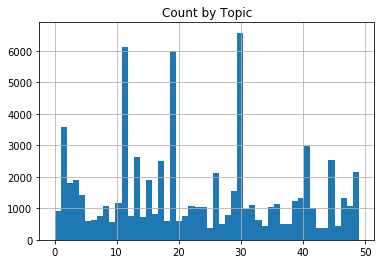

In [15]:
data['top_topic'].hist(bins=50)
plt.title('Count by Topic')
plt.show()

In [19]:
lda_50_45 = gensim.models.ldamodel.LdaModel.load('lda_50_45_model')

In [21]:
topics_to_csv(data, 50)